In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import gc
import re
from pprint import pprint
from scipy.stats import ttest_ind

In [3]:
# 
folder_path = Path('./DS_experiment_data/AV path planning experiment/')
folders = folder_path.glob('*')
BASELINE_SUCCESS = 0
BASELINE_FAILURE = 0
PROPOSED_SUCCESS = 0
PROPOSED_FAILURE = 0
for folder in folders:
    csv_files = folder.glob('*.csv')
    for file_path in csv_files:
        file_path = str(file_path)
        if 'BaseLine' in file_path:
            if 'success' in file_path:
                BASELINE_SUCCESS += 1
            elif 'failure' in file_path:
                BASELINE_FAILURE += 1
            else:
                print('NO')
        elif 'Proposed' in file_path:
            if 'success' in file_path:
                PROPOSED_SUCCESS += 1
            elif 'failure' in file_path:
                PROPOSED_FAILURE += 1
            else:
                print('NO')
        else:
            print('NO')
print(BASELINE_FAILURE, BASELINE_SUCCESS, PROPOSED_FAILURE, PROPOSED_SUCCESS)
print('Baseline success rate:',round(BASELINE_SUCCESS/(BASELINE_FAILURE+BASELINE_SUCCESS),4))
print('Prposed success rate:',round(PROPOSED_SUCCESS/(PROPOSED_FAILURE+PROPOSED_SUCCESS),4))

160 140 112 188
Baseline success rate: 0.4667
Prposed success rate: 0.6267


In [4]:
# Counting each case
Proposed_distance_v_diff_count = [[0,0,0] for _ in range(3)]
Baseline_distance_v_diff_count = [[0,0,0] for _ in range(3)]
folder_path = Path('./DS_experiment_data/AV path planning experiment/')
folders = folder_path.glob('*')
for folder in folders:
    csv_files = folder.glob('*.csv')
    for file_path in csv_files:
        filename = str(file_path).split("\\")[-1]
        parts = filename.split('_')
        if 'Proposed' in str(file_path):
            Proposed_distance_v_diff_count[int(parts[1])//10-1][int(parts[2])//10-1]+=1
        else:
            Baseline_distance_v_diff_count[int(parts[1])//10-1][int(parts[2])//10-1]+=1

print('Proposed model cases')
print('Vdiff: 10, 20, 30')
for i, col in enumerate(Proposed_distance_v_diff_count):

    print((i+1)*10,'m',col)
print('')
print('Baseline model cases')
print('Vdiff: 10, 20, 30')
for i, col in enumerate(Baseline_distance_v_diff_count):
    print((i+1)*10,'m',col)

Proposed model cases
Vdiff: 10, 20, 30
10 m [33, 37, 31]
20 m [34, 32, 35]
30 m [37, 30, 31]

Baseline model cases
Vdiff: 10, 20, 30
10 m [35, 34, 31]
20 m [36, 34, 35]
30 m [34, 30, 31]


In [5]:
# Counting Ego speed case
Proposed_ego_speed = [0,0,0]
Baseline_ego_speed = [0,0,0]
folder_path = Path('./DS_experiment_data/AV path planning experiment/')
folders = folder_path.glob('*')
for folder in folders:
    csv_files = folder.glob('*.csv')
    for file_path in csv_files:
        filename = str(file_path).split("\\")[-1]
        parts = filename.split('_')
        if 'Proposed' in str(file_path):
            Proposed_ego_speed[int(parts[3])//10-4]+=1
        else:
            Baseline_ego_speed[int(parts[3])//10-4]+=1

print(Proposed_ego_speed)
print(Baseline_ego_speed)

[87, 112, 101]
[90, 119, 91]


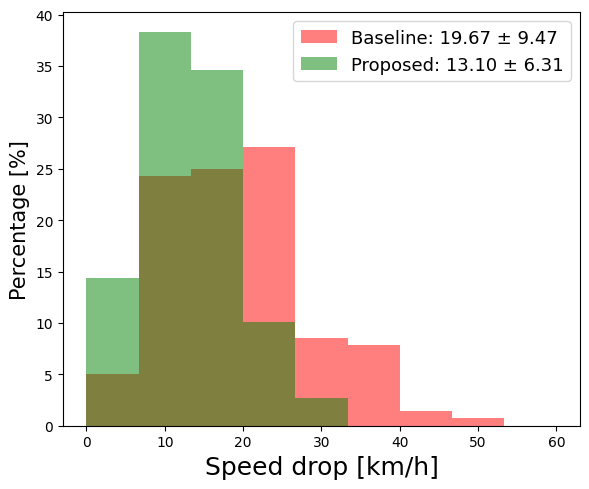

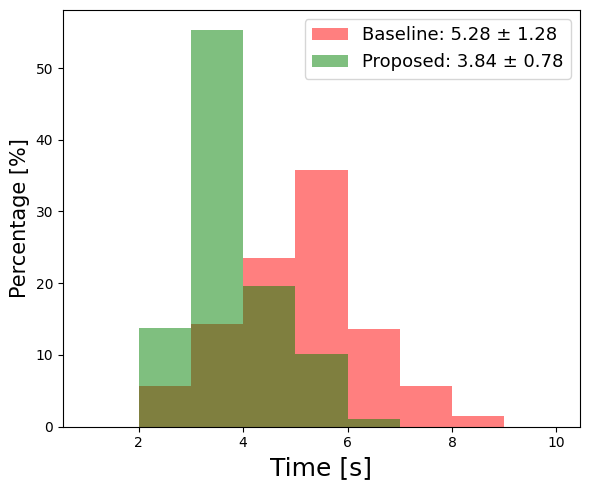

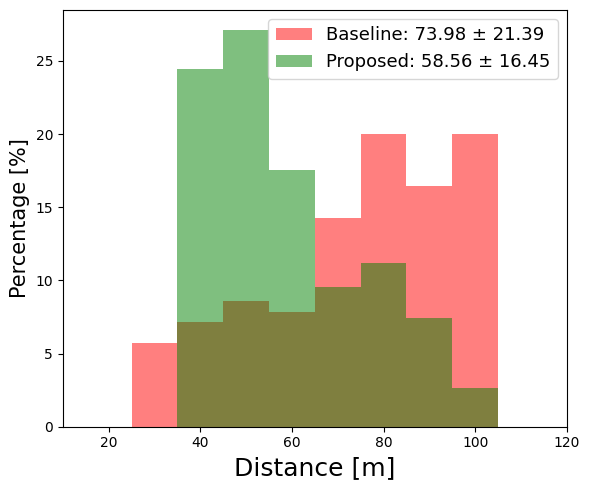

19.6744 13.0959
5.2786 3.8396
73.9817 58.5568


In [6]:
# Obtain speed drop & interaction duration in success case
folder_path = Path('./DS_experiment_data/AV path planning experiment/')
folders = folder_path.glob('*')
baseline_speed_diff = []
proposed_speed_diff = []
baseline_interaction_duration = []
proposed_interaction_duration = []
travled_distance = [[],[]]
y_coordinate = [[],[]]
temp_count = 0

for folder in folders:
    csv_files = folder.glob('*.csv')
    for file_path in csv_files:
        filename = str(file_path).split("\\")[-1]
        if 'success' in str(file_path):
            data = pd.read_csv(file_path)
            parts = filename.split('_')
            before_done_data = data[data['Process state'] != 'DONE']
            
            speed_min_idx = before_done_data['speed_FV'].idxmin()

            speed_drop = before_done_data.loc[:speed_min_idx]['speed_FV'].max()-min(before_done_data['speed_FV'])
            # speed_drop = max(before_done_data['speed_FV'])-min(before_done_data['speed_FV'])
            interaction_duration = max(before_done_data['Time'])-min(before_done_data['Time'])
            distance = before_done_data['y_MV'].max() - before_done_data['y_MV'].min()
            y = -40-before_done_data['y_MV'].min()
            
            if 'BaseLine' in str(file_path):
                baseline_speed_diff.append(speed_drop)
                baseline_interaction_duration.append(interaction_duration)
                travled_distance[0].append(distance)
                y_coordinate[0].append(y)
                # if (speed_drop > 10): # & (before_done_data['y_MV'].min() < -120):
                #     temp_count +=1
                #     print(file_path)
            else:
                proposed_speed_diff.append(speed_drop)
                proposed_interaction_duration.append(interaction_duration)
                travled_distance[1].append(distance)
                y_coordinate[1].append(y)
    # print('')
# print(temp_count)

plt.figure(figsize=(6,5))
ax1 = plt.subplot(1,1,1)
bins = np.linspace(0, 60, 10)
weights = np.ones_like(baseline_speed_diff) / len(baseline_speed_diff) * 100
ax1.hist(baseline_speed_diff, alpha = 0.5, weights=weights, bins = bins,color = 'r')
weights = np.ones_like(proposed_speed_diff) / len(proposed_speed_diff) * 100
ax1.hist(proposed_speed_diff, alpha = 0.5, weights=weights, bins = bins,color = 'g')
ax1.set_xlabel('Speed drop [km/h]',fontsize = 18)
ax1.set_ylabel('Percentage [%]',fontsize = 15)
# ax1.set_title('Speed drop of FV',fontsize = 20)
mean_baseline1 = np.array(baseline_speed_diff).mean()
std_baseline1 = np.array(baseline_speed_diff).std()
mean_proposed1 = np.array(proposed_speed_diff).mean()
std_proposed1 = np.array(proposed_speed_diff).std()
legend_str1 = [f'Baseline: {mean_baseline1:.2f} ± {std_baseline1:.2f}',
               f'Proposed: {mean_proposed1:.2f} ± {std_proposed1:.2f}']
ax1.legend(legend_str1, loc='upper right', fontsize = 13)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
ax2 = plt.subplot(1,1,1)
bins = np.linspace(1, 10, 10)
weights = np.ones_like(baseline_interaction_duration) / len(baseline_interaction_duration) * 100
ax2.hist(baseline_interaction_duration, alpha = 0.5, weights=weights, bins = bins,color = 'r')
weights = np.ones_like(proposed_interaction_duration) / len(proposed_interaction_duration) * 100
ax2.hist(proposed_interaction_duration, alpha = 0.5, weights=weights, bins = bins,color = 'g')
ax2.set_xlabel('Time [s]',fontsize = 18)
ax2.set_ylabel('Percentage [%]',fontsize = 15)
# ax2.set_title('Required merging time of AV',fontsize = 20)
mean_baseline2 = np.array(baseline_interaction_duration).mean()
std_baseline2 = np.array(baseline_interaction_duration).std()
mean_proposed2 = np.array(proposed_interaction_duration).mean()
std_proposed2 = np.array(proposed_interaction_duration).std()
legend_str2 = [f'Baseline: {mean_baseline2:.2f} ± {std_baseline2:.2f}',
               f'Proposed: {mean_proposed2:.2f} ± {std_proposed2:.2f}']
ax2.legend(legend_str2, loc='upper right', fontsize = 13)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
ax3 = plt.subplot(1,1,1)
bins = np.linspace(15, 115, 11)
weights = np.ones_like(travled_distance[0]) / len(travled_distance[0]) * 100
ax3.hist(travled_distance[0], alpha = 0.5, weights=weights, bins = bins,color = 'r')
weights = np.ones_like(travled_distance[1]) / len(travled_distance[1]) * 100
ax3.hist(travled_distance[1], alpha = 0.5, weights=weights, bins = bins,color = 'g')
ax3.set_xlabel('Distance [m]',fontsize = 18)
ax3.set_ylabel('Percentage [%]',fontsize = 15)
# ax3.set_title('Distance traveled of AV in current lane',fontsize = 20)
mean_baseline3 = np.array(travled_distance[0]).mean()
std_baseline3 = np.array(travled_distance[0]).std()
mean_proposed3 = np.array(travled_distance[1]).mean()
std_proposed3 = np.array(travled_distance[1]).std()
legend_str3 = [f'Baseline: {mean_baseline3:.2f} ± {std_baseline3:.2f}',
               f'Proposed: {mean_proposed3:.2f} ± {std_proposed3:.2f}']
ax3.legend(legend_str3, loc='upper right', fontsize = 13)
plt.tight_layout()
plt.show()


print(round(sum(baseline_speed_diff)/len(baseline_speed_diff),4), round(sum(proposed_speed_diff)/len(proposed_speed_diff),4))
print(round(sum(baseline_interaction_duration)/len(baseline_interaction_duration),4), round(sum(proposed_interaction_duration)/len(proposed_interaction_duration),4))
print(round(sum(travled_distance[0])/len(travled_distance[0]),4), round(sum(travled_distance[1])/len(travled_distance[1]),4))



In [14]:
np.array(baseline_speed_diff).std()

9.465955392729402

In [23]:
baseline_speed_mean = sum(baseline_speed_diff) / len(baseline_speed_diff)
proposed_speed_mean = sum(proposed_speed_diff) / len(proposed_speed_diff)
baseline_duration_mean = sum(baseline_interaction_duration) / len(baseline_interaction_duration)
proposed_duration_mean = sum(proposed_interaction_duration) / len(proposed_interaction_duration)

# t-검정 수행
speed_t_test = ttest_ind(baseline_speed_diff, proposed_speed_diff, equal_var=False)
duration_t_test = ttest_ind(baseline_interaction_duration, proposed_interaction_duration, equal_var=False)

# 결과 출력
print(f"Speed Drop:           Baseline mean = {baseline_speed_mean:0.3f}, Proposed mean = {proposed_speed_mean:0.3f}")
print(f"Interaction Duration: Baseline mean = {baseline_duration_mean:0.3f}, Proposed mean = {proposed_duration_mean:0.3f}")
print(f"Speed Drop t-test p-value:            {speed_t_test.pvalue:0.5f}")
print(f"Interaction Duration t-test p-value:  {duration_t_test.pvalue:0.5f}")


Speed Drop:           Baseline mean = 19.674, Proposed mean = 13.096
Interaction Duration: Baseline mean = 5.279, Proposed mean = 3.840
Speed Drop t-test p-value:            0.00000
Interaction Duration t-test p-value:  0.00000


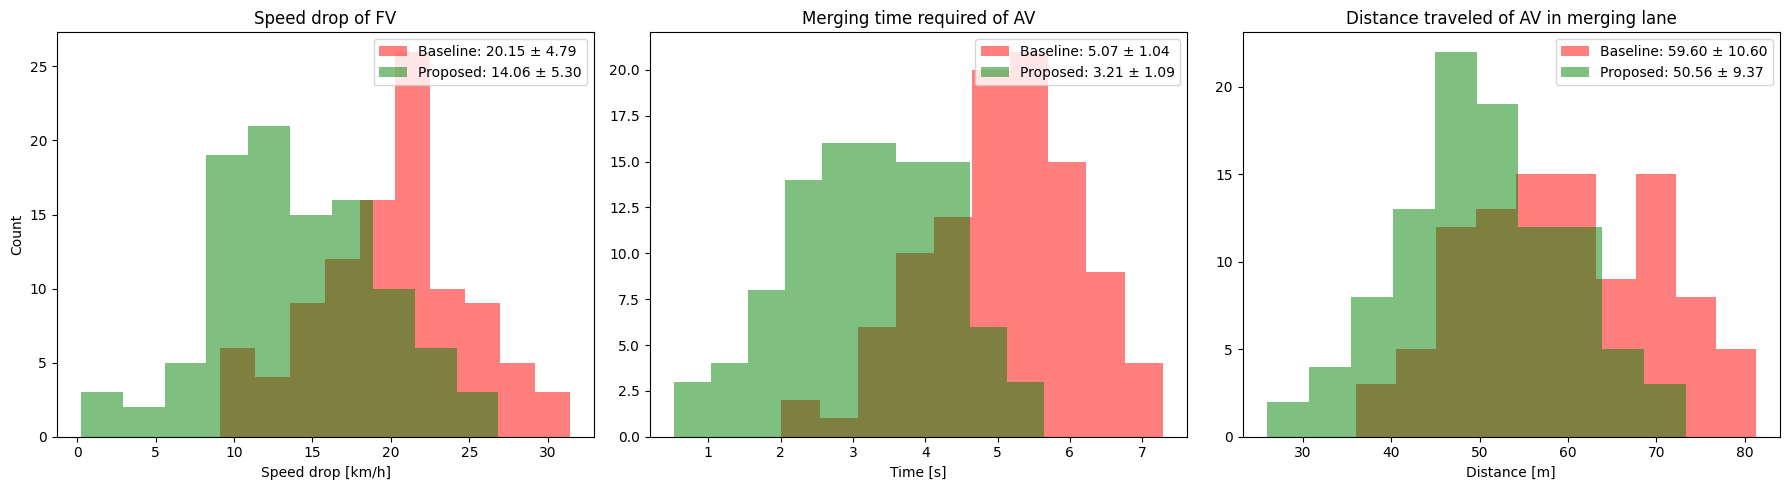

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 임의의 데이터 생성
baseline_data1 = np.random.normal(loc=20, scale=5, size=100)
proposed_data1 = np.random.normal(loc=15, scale=5, size=100)
baseline_data2 = np.random.normal(loc=5, scale=1, size=100)
proposed_data2 = np.random.normal(loc=3, scale=1, size=100)
baseline_data3 = np.random.normal(loc=60, scale=10, size=100)
proposed_data3 = np.random.normal(loc=50, scale=10, size=100)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 첫 번째 subplot: Speed drop of FV
axes[0].hist(baseline_data1, bins=10, alpha=0.5, color='red', label='_nolegend_')
axes[0].hist(proposed_data1, bins=10, alpha=0.5, color='green', label='_nolegend_')
axes[0].set_title('Speed drop of FV')
axes[0].set_xlabel('Speed drop [km/h]')
axes[0].set_ylabel('Count')

mean_baseline1 = np.mean(baseline_data1)
std_baseline1 = np.std(baseline_data1)
mean_proposed1 = np.mean(proposed_data1)
std_proposed1 = np.std(proposed_data1)

# 범례 추가
legend_str1 = [f'Baseline: {mean_baseline1:.2f} ± {std_baseline1:.2f}',
               f'Proposed: {mean_proposed1:.2f} ± {std_proposed1:.2f}']
axes[0].legend(legend_str1, loc='upper right')

# 두 번째 subplot: Merging time required of AV
axes[1].hist(baseline_data2, bins=10, alpha=0.5, color='red', label='_nolegend_')
axes[1].hist(proposed_data2, bins=10, alpha=0.5, color='green', label='_nolegend_')
axes[1].set_title('Merging time required of AV')
axes[1].set_xlabel('Time [s]')

mean_baseline2 = np.mean(baseline_data2)
std_baseline2 = np.std(baseline_data2)
mean_proposed2 = np.mean(proposed_data2)
std_proposed2 = np.std(proposed_data2)

# 범례 추가
legend_str2 = [f'Baseline: {mean_baseline2:.2f} ± {std_baseline2:.2f}',
               f'Proposed: {mean_proposed2:.2f} ± {std_proposed2:.2f}']
axes[1].legend(legend_str2, loc='upper right')

# 세 번째 subplot: Distance traveled of AV in merging lane
axes[2].hist(baseline_data3, bins=10, alpha=0.5, color='red', label='_nolegend_')
axes[2].hist(proposed_data3, bins=10, alpha=0.5, color='green', label='_nolegend_')
axes[2].set_title('Distance traveled of AV in merging lane')
axes[2].set_xlabel('Distance [m]')

mean_baseline3 = np.mean(baseline_data3)
std_baseline3 = np.std(baseline_data3)
mean_proposed3 = np.mean(proposed_data3)
std_proposed3 = np.std(proposed_data3)

# 범례 추가
legend_str3 = [f'Baseline: {mean_baseline3:.2f} ± {std_baseline3:.2f}',
               f'Proposed: {mean_proposed3:.2f} ± {std_proposed3:.2f}']
axes[2].legend(legend_str3, loc='upper right')

plt.tight_layout()
plt.show()


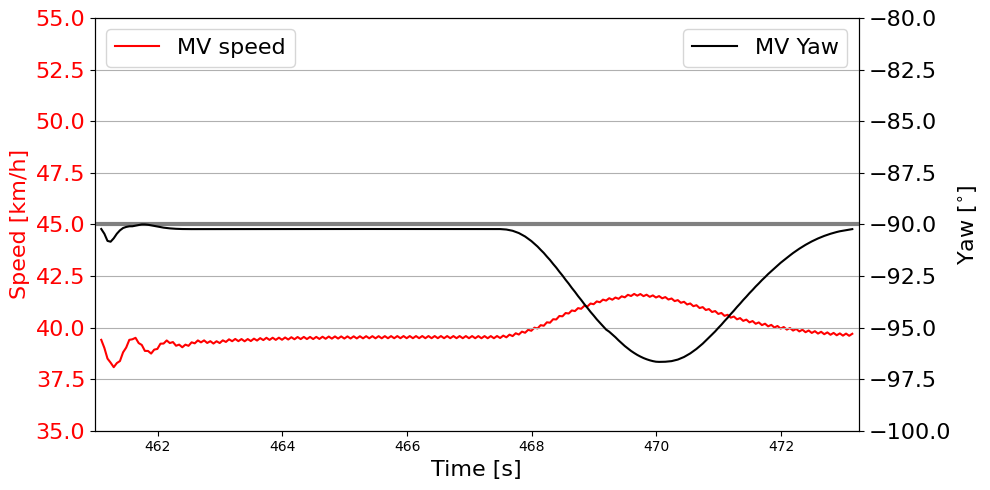

In [29]:
import pandas as pd

import matplotlib.pyplot as plt

# Attempting to read the first few lines of the file manually to understand its format and content
file_path = 'DS_experiment_data/AV path planning experiment/박현철/BaseLine_20_20_40_failure.csv'

data = pd.read_csv(file_path)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the MV speed on the primary y-axis
color = 'red'
ax1.set_xlabel('Time [s]', fontsize = 16)
ax1.set_ylabel('Speed [km/h]', color=color, fontsize = 16)
ax1.plot(data['Time'], data['speed_MV'], color=color, label='MV speed')
ax1.tick_params(axis='y', labelcolor=color, labelsize = 16)
ax1.set_ylim([35,55])

# Create a second y-axis for the yaw values
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'k'
ax2.set_ylabel('Yaw [$^{\circ}$]', color=color, fontsize = 16)  # we already handled the x-label with ax1
ax2.hlines(y=-90, xmin=460,xmax=475, linewidth = 3, color='grey')

ax2.plot(data['Time'], data['Yaw_MV'], color=color, label='MV Yaw')
ax2.tick_params(axis='y', labelcolor = color, labelsize = 16)
ax2.set_ylim([-100,-80])
ax1.legend(loc='upper left',fontsize = 16)  # Legend for MV Speed
ax2.legend(loc='upper right',fontsize = 16)  # Legend for Yaw

ax2.set_xlim([data['Time'].min()-0.1,data['Time'].max()+0.1])

# Title and grid
plt.grid(True)

# Show the plot
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


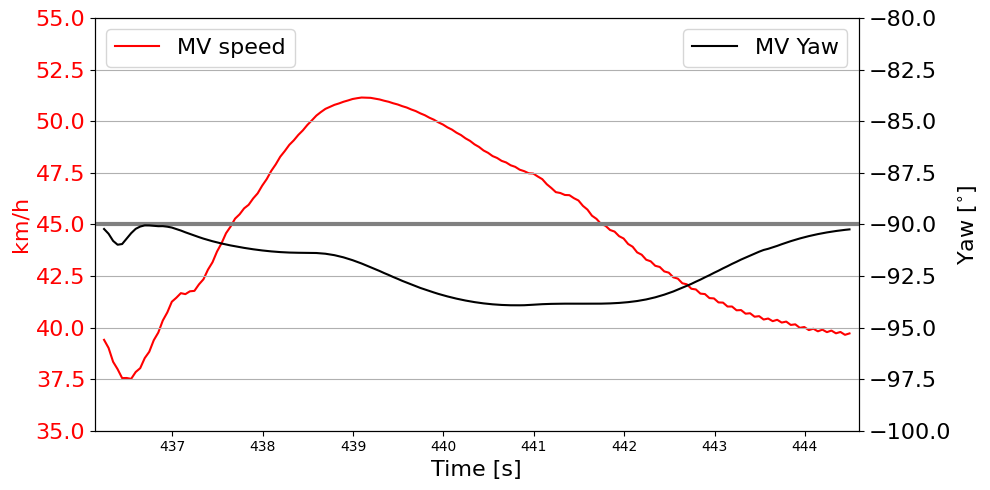

In [30]:
# Attempting to read the first few lines of the file manually to understand its format and content
file_path = 'DS_experiment_data/AV path planning experiment/박현철/Proposed_20_20_40_success.csv'

data = pd.read_csv(file_path)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the MV speed on the primary y-axis
color = 'red'
ax1.set_xlabel('Time [s]', fontsize = 16)
ax1.set_ylabel('km/h', color=color, fontsize = 16)
ax1.plot(data['Time'], data['speed_MV'], color=color, label='MV speed')
ax1.tick_params(axis='y', labelcolor=color, labelsize = 16)
ax1.set_ylim([35,55])

# Create a second y-axis for the yaw values
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'k'
ax2.set_ylabel('Yaw [$^{\circ}$]', color=color, fontsize = 16)  # we already handled the x-label with ax1
ax2.hlines(y=-90, xmin=435,xmax=445, linewidth = 3, color='grey')
ax2.plot(data['Time'], data['Yaw_MV'], color=color, label='MV Yaw')
ax2.tick_params(axis='y', labelcolor=color, labelsize = 16)
ax2.set_ylim([-100,-80])
ax1.legend(loc='upper left',fontsize = 16)  # Legend for MV Speed
ax2.legend(loc='upper right',fontsize = 16)  # Legend for Yaw
ax2.set_xlim([data['Time'].min()-0.1,data['Time'].max()+0.1])
# Title and grid
plt.grid(True)

# Show the plot
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()